# COVID19 International V2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-raw-data-and-adjust-for-anomalies" data-toc-modified-id="Get-the-raw-data-and-adjust-for-anomalies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the raw data and adjust for anomalies</a></span><ul class="toc-item"><li><span><a href="#Nation-naming-stuff" data-toc-modified-id="Nation-naming-stuff-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Nation naming stuff</a></span></li><li><span><a href="#Population-data-retrieval" data-toc-modified-id="Population-data-retrieval-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Population data retrieval</a></span></li><li><span><a href="#COVID-data-retrieval-and-adjustment-for-outliers" data-toc-modified-id="COVID-data-retrieval-and-adjustment-for-outliers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>COVID data retrieval and adjustment for outliers</a></span></li></ul></li><li><span><a href="#Plot-weekly-new-case/deaths-data-from-January-2020" data-toc-modified-id="Plot-weekly-new-case/deaths-data-from-January-2020-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot weekly new-case/deaths data from January 2020</a></span></li><li><span><a href="#Plot-new-vs-cumulative-(all-and-last-3-months)" data-toc-modified-id="Plot-new-vs-cumulative-(all-and-last-3-months)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot new-vs-cumulative (all and last 3 months)</a></span></li><li><span><a href="#International-comparisons---maps/leader-boards/swarms" data-toc-modified-id="International-comparisons---maps/leader-boards/swarms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>International comparisons - maps/leader-boards/swarms</a></span></li></ul></div>

## Python setup

In [32]:
# system imports
import sys
from pathlib import Path

#analytic imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import matplotlib.units as munits
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import geopandas as gpd
import iso3166

# COVID19 specific imports
sys.path.append(r'../bin')
from datagrabber import get_data, get_population_from_eu
import plotstuff as ps

# directory
CHART_DIRECTORY = '../charts'
I_PREFIX = '/!I-'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)

# display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('ggplot')
register_matplotlib_converters()

## Get the raw data and adjust for anomalies

### Nation naming stuff

In [2]:
# make country names ISO compliant
iso_name_map = {
    # from              # to
    "Bolivia":          "Bolivia, Plurinational State of",
    "Bonaire, Saint Eustatius And Saba": "Bonaire, Sint Eustatius and Saba",
    "British Virgin Islands": "Virgin Islands, British",
    "Brunei":           "Brunei Darussalam",
    "Cape Verde":       "Cabo Verde",
    "Cote D'Ivoire":    "Côte d'Ivoire",
    "Curaã§Ao":         "Curaçao",
    "Democratic Republic Of Congo": "Congo, Democratic Republic of the",
    "Guinea Bissau":    "Guinea-Bissau",
    "Vatican":          "Holy See",
    "Iran":             "Iran, Islamic Republic of",
    "Laos":             "Lao People's Democratic Republic",
    "Moldova":          "Moldova, Republic of",
    "Russia":           "Russian Federation",
    "Sint Maarten":     "Sint Maarten (Dutch part)",
    "South Korea":      "Korea, Republic of",
    "Syria":            "Syrian Arab Republic",
    "Timor Leste":      "Timor-Leste",
    "United Kingdom":   "United Kingdom of Great Britain and Northern Ireland",
    "United Republic Of Tanzania": "Tanzania, United Republic of",
    "United States":    "United States of America",
    "United States Virgin Islands":   "Virgin Islands, U.S.",
    "Venezuela":        "Venezuela, Bolivarian Republic of",
    "Vietnam":          "Viet Nam",
}

must_name_map = {
    # these names from the EU source are ugly and we will change anyway
    "Cote D'Ivoire":    "Côte d'Ivoire",
    "Curaã§Ao":         "Curaçao",
}

def name_map(object_, map_):
    """Rename the index of a Series or the columns of a DataFrame
       The renaming is done in place.
       Parameters
       - object_ - the pandas Series or DataFrame
       - map_ - a dictionary of old to new mappings 
       Returns: None """

    fixing = {}
    if isinstance(object_, pd.Series):
        for name in map_:
            if name in object_.index:
                fixing[name] = map_[name]
        object_.rename(index=fixing, inplace=True)
    else:
        for name in map_:
            if name in object_.columns:
                fixing[name] = map_[name]
        object_.rename(columns=fixing, inplace=True)
    
    return None

### Population data retrieval

In [3]:
# get population data
population = get_population_from_eu()
population = population[population.columns[0]] # to Series
name_map(population, must_name_map)

Retrieving data from: https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-11-30.xlsx
https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-11-30.xlsx


### COVID data retrieval and adjustment for outliers

In [4]:
# get case data 
DATA_SOURCE = 'EU' # 'EU' or 'OWID'
CASES = 0
DEATHS = 1
modes = {
    'Cases': CASES,
    'Deaths': DEATHS,
}
raw_cum_data = [None, None]
raw_daily_data = [None, None]
adj_daily_data = [None, None]
adj_cum_data = [None, None]

data_quality = [None, None]

for mode, index in modes.items():
    
    # get the raw data
    raw_cum_data[index], source = get_data(data_type=mode.lower(),
                                     from_where=DATA_SOURCE)
    name_map(raw_cum_data[index], must_name_map)
    
    # make missing data zero
    raw_cum_data[index] = raw_cum_data[index].fillna(0)
    
    # adjust data for anomalies
    (raw_daily_data[index], 
        adj_daily_data[index], 
        adj_cum_data[index]) = ps.dataframe_correction(
                                    raw_cum_data[index])
    
    # identify whether the adjustment for anomalies 
    # changed the data
    data_quality[index] = pd.Series(None, 
                            index=raw_cum_data[index].columns,
                            dtype='str')
    for col in raw_cum_data[index].columns:
        if (raw_daily_data[index][col] == 
            adj_daily_data[index][col]).all():
            data_quality[index][col] = (f'Source: {source}, '
                                         'original data')
        else:
            data_quality[index][col] = (f'Source: {source}, '
                            'data adjusted for extreme outliers')

Data retrieved from the lake
Spikes in Andorra
DateRep  2020-06-03
spike     79.000000
mean       0.714286
zeros     10.000000
Data too sparse in Anguilla (max_consecutive=1)
Data too sparse in Antigua And Barbuda (max_consecutive=2)
Data too sparse in Barbados (max_consecutive=11)
Negatives in Benin
DateRep
2020-05-20   -209.0
Name: Benin, dtype: float64
Data too sparse in Benin (max_consecutive=10)
Data too sparse in Bermuda (max_consecutive=3)
Data too sparse in Bhutan (max_consecutive=6)
Data too sparse in Bonaire, Saint Eustatius And Saba (max_consecutive=5)
Data too sparse in Botswana (max_consecutive=2)
Data too sparse in British Virgin Islands (max_consecutive=2)
Spikes in Burkina Faso
DateRep  2020-05-07  2020-09-14
spike     41.000000  193.000000
mean       6.714286   14.714286
zeros      0.000000    0.000000
Data too sparse in Burundi (max_consecutive=11)
Data too sparse in Cambodia (max_consecutive=11)
Data too sparse in Cameroon (max_consecutive=10)
Spikes in Cape Verde
Da

Data too sparse in Côte d'Ivoire (max_consecutive=5)
Data too sparse in Cuba (max_consecutive=14)
Data too sparse in Curaçao (max_consecutive=1)
Data too sparse in Cyprus (max_consecutive=6)
Negatives in Czechia
DateRep
2020-07-05   -1.0
2020-07-06   -3.0
Name: Czechia, dtype: float64
Data too sparse in Democratic Republic Of Congo (max_consecutive=9)
Data too sparse in Djibouti (max_consecutive=4)
Data too sparse in Dominica (max_consecutive=0)
Spikes in Ecuador
DateRep   2020-09-07  2020-10-09
spike    3800.000000       398.0
mean       40.428571        39.5
zeros       0.000000         0.0
Data too sparse in Equatorial Guinea (max_consecutive=2)
Data too sparse in Eritrea (max_consecutive=0)
Data too sparse in Estonia (max_consecutive=9)
Data too sparse in Eswatini (max_consecutive=8)
Data too sparse in Falkland Islands (Malvinas) (max_consecutive=0)
Data too sparse in Faroe Islands (max_consecutive=0)
Data too sparse in Fiji (max_consecutive=1)
Spikes in Finland
DateRep  2020-04-22

## Plot weekly new-case/deaths data from January 2020

In [5]:
def plot_weekly(daily, mode, data_quality, dfrom="2020-01-21"):
    """Plot weekly bar charts for daily new cases and deaths
        Function paramters:
        - daily is a DataFrame of daily timeseries data
        - mode is one of 'cases' or 'deaths' 
        - data_quality is a Series of strings,
            used for the left footnote on charts
        - dfrom is a date string to display from
        Returns: weekly data in a DataFrame """
    
    DISPLAY_FROM = pd.Timestamp(dfrom)
    
    # find the day that the week ends - last day of dataframe
    LAST_DAY = daily.index[-1]
    RULE = {
        0: 'W-MON',
        1: 'W-TUE',
        2: 'W-WED',
        3: 'W-THU',
        4: 'W-FRI',
        5: 'W-SAT',
        6: 'W-SUN',
    }[LAST_DAY.dayofweek]

    # convert the data to weekly
    returnable = weekly = daily.resample(rule=RULE, 
                                         closed='right').sum()
    total = weekly.sum()
    
    # adjust data and dates for plotting
    # we move the data by half a week becuase 
    # we want the bars to be centred
    weekly = weekly[weekly.index > DISPLAY_FROM]
    weekly.index = weekly.index - pd.Timedelta(3.5, unit='d')
    
    for name in daily.columns:
    
        # avoid plotting an empty plot
        if total[name] == 0: continue
    
        # plot the data
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.bar(weekly.index, weekly[name], width=5, color='#dd0000', )
        ax.margins(0.01)
            
        # This makes the dates for xticklabels look a little nicer
        locator = mdates.AutoDateLocator(minticks=4, maxticks=13)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

        # label the plot
        ax.set_title(f'COVID-19 {mode.title()}: {name}')
        ax.set_ylabel(f'New {mode.lower()}/week ending '
                      f'{RULE[-3:].title()}')
        ax.set_xlabel(None)
        
        # adjust y-limits to be prettier, 
        # assume ylim[0] is zero
        # this adjustment should not be needed, but it is
        ylim = ax.get_ylim()
        ylim = ylim[0], ylim[1] * 1.025
        ax.set_ylim(ylim)
        if ylim[0] != 0:
            # this should not happen - ever.
            print(f'Warning: ylim[0] is {ylim[0]} for {name}')
        
        # an ugly kludge for putting commas in the ylabels
        def small(x): return np.round(x, 2)
        def big(x): return int(x)
        functor = small if weekly[name].max() <= 4 else big
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(
                lambda x, p: format(functor(x), ',')))
            
        fig = ax.figure
        
        # footnote the plot
        fig.text(0.01, 0.01, 
            data_quality[index][name],
            ha='left', va='bottom',
            fontsize=9, fontstyle='italic',
            color='#999999')
        fig.text(0.99, 0.01, 
            f'Total {mode.lower()}: {int(total[name]):,}',
            ha='right', va='bottom',
            fontsize=9, fontstyle='italic',
            color='#999999')

        # final tidy - save - close
        fig.tight_layout(pad=1.2)
        #plt.show()
        fig.savefig(
            f'{CHART_DIRECTORY}/{name}-{mode.lower()}-new-weekly', 
            dpi=125)
        plt.close()
        
    return returnable

In [6]:
if True: # switch this output on/off
    adj_weekly_data = [None, None]
    for (mode, index) in modes.items():
        daily = adj_daily_data[index]
        adj_weekly_data[index] = plot_weekly(daily, mode.lower(), 
                                             data_quality)

## Plot new-vs-cumulative (all and last 3 months)

In [7]:
if True: # switch this output on/off

    THREE_MONTHS = 93 # days
    periods = [0, THREE_MONTHS]

    tags = ["full", "3months"]  
    for period, tag in zip(periods, tags):
        for mode, index in modes.items():
            for name in adj_cum_data[index].columns:
        
                # let's not plot empty charts
                if adj_daily_data[index][name][-period:].sum() == 0: 
                    continue
            
                ps.plot_new_cum(
                    adj_daily_data[index][name][-period:].copy(), 
                    adj_cum_data[index][name][-period:].copy(), 
                    mode, name, 
                    title=f'{name}: COVID-19 {mode.title()}',
                    rfooter=data_quality[index][name],
                    tight=1.2, 
                    savefig=f'{CHART_DIRECTORY}/{name}-{mode.lower()}'
                                f'-new-vs-cum-{tag}.png'
                )

## International comparisons - maps/leader-boards/swarms

In [60]:
def per_million_population(population: pd.Series, power:int = 6):
    
    factor = 10 ** power
    return power, factor, population / factor

In [20]:
def get_rear_offsets(dataframe, period):
    """Get offset to last non-zero values in dataframe by col
       provided offset is within period, otherwise zero offset
       [We do this becuase some nations are slow in reporting,
       and without this adjustment late reporting nations would 
       look better than they actually are.]"""
    
    nrows = len(dataframe)
    rear_offsets = pd.Series(0, index=dataframe.columns)
    for col in dataframe.columns:
        index_array = (np.nonzero(dataframe[col].to_numpy()))[0]
        if len(index_array) > 0:
            last = index_array[-1]
            rear_offsets[col] = nrows - last - 1
            # Note: rear_offsets[col] is 0 if len(index_array) == 0
    rear_offsets = rear_offsets.where(rear_offsets<=period, other=0)
    return rear_offsets

def get_recent_total(dataframe, rear_offsets, period):
    """Sum the last rows of a dataframe, making adjustments
       for zero rows at the very end"""
    
    daily_sum = pd.Series(0.0, index=dataframe.columns)
    for col in dataframe.columns:
        p = 0 - (period+rear_offsets[col])
        daily_sum[col] = dataframe[col].iloc[p:].sum()
    return daily_sum

def get_larger_nations(population, thresh=100_000):
    """return a list of nations with a population exceeding thresh"""
    
    return population[population >= thresh].index

In [61]:
def map_world(series: pd.Series, title: str, legend_title: str):
    
    # prepare data for mapping
    name_map(series, iso_name_map)
    score = pd.DataFrame(series) # back to DataFrame
    score.columns = ['Score']
    score['country'] = score.index
    score['code'] = [iso3166.countries.get(x.upper())[2] 
                     for x in score['country']]
    
    # get map data
    shapefile = ('../geo-data/ne_110m_admin_0_countries/'
        'ne_110m_admin_0_countries.shp')
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
    gdf.columns = ['country', 'country_code', 'geometry']
    gdf = gdf[gdf['country'] != 'Antarctica'] 
    
    merged = gdf.merge(score,
                       left_on='country_code', 
                       right_on='code', how='left')

    variable = 'Score'
    cmap = mpl.cm.get_cmap('viridis').reversed()
    cmap.set_bad('white')
    cmap.set_under('white')
    ax = merged.plot(column=variable, cmap=cmap, legend=False)
    ax.set_title(title)
    
    # remove ticks and labels from the map
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # colorbar
    world_map = ax.collections[0]
    cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')
    
    # legend title
    fig = ax.figure
    fig.text(0.5, 0.175, legend_title,
        ha='center', va='bottom',
        fontsize=12, # fontstyle='italic',
        color='#222222')
    
    # wrap-up
    fig.set_size_inches(8, 5)
    fig.tight_layout()
    fig.savefig(f'{CHART_DIRECTORY}'+
                f'{I_PREFIX}MAP-{title}.png', 
                dpi=125)
    #plt.show()
    plt.close()

In [58]:
def swarm(data: pd.Series,
          title="Don't forget the title",
          ylabel="Don't forget the ylabel",
          color='cornflowerblue'):
    
    # get country information
    wbd = pd.read_excel('../data/CLASS.xls', header=4, index_col=0, 
                        na=['x']).iloc[1:219].dropna(how='all', axis=1)
    mapping = wbd['Income group']
    mapping.index = wbd['Code']
    
    # - prepare for plot
    name_map(data, iso_name_map)
    data = pd.DataFrame(data)
    data.columns = ['Rate']
    data['alpha3'] = [iso3166.countries.get(x).alpha3 for x in data.index]
    data['alpha2'] = [iso3166.countries.get(x).alpha2 for x in data.index]
    data['Income Group'] = data.alpha3.map(mapping)
    data = data[data['Income Group'].notna()]
    
    # labels 
    data['alpha2'] = data['alpha2'].where(data['alpha2'].notna(), other='')
    
    # swarm plot
    # - set up
    categories = ['Low income', 'Lower middle income',
                                'Upper middle income', 'High income']
    # - plot
    fig, ax = plt.subplots(figsize=(8,5))
    sns.swarmplot(x='Income Group', y='Rate', data=data, 
                       size=10,
                       dodge=True, 
                       color=color, alpha=0.5,
                       order=categories,
                       ax=ax)
    
    # - point annotation - this is one ugly hack
    for collect, name in zip(ax.collections, categories):
        
        # retrieve positional data from plot
        op = collect.get_offset_position()
        collect.set_offset_position('data')
        retrieved_xy_pairs = collect.get_offsets()
        collect.set_offset_position(op)
        
        # build an xy map with duplicate keys
        THRESH = 7
        dup_map = {}
        for x, y in retrieved_xy_pairs:
            yy = np.round(y, THRESH)
            if yy in dup_map:
                dup_map[yy].append(x)
            else:
                dup_map[yy] = [x]
        
        # use this map to plot in the data labels
        for index, row in data[data['Income Group'] == name].iterrows():
            lookup = np.round(row['Rate'], THRESH)
            if lookup in dup_map:
                ax.text(dup_map[lookup].pop(), row['Rate'], row['alpha2'],
                       ha='center', va='center', fontsize='xx-small', 
                        color='#333333')
        
    # - plot labelling 
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    
    # plot finalisation
    fig = ax.figure
    fig.tight_layout()

    fig.savefig(f'{CHART_DIRECTORY}{I_PREFIX}SWARM-{title}.png', dpi=125)
 
    #plt.show()
    plt.close()

Cases


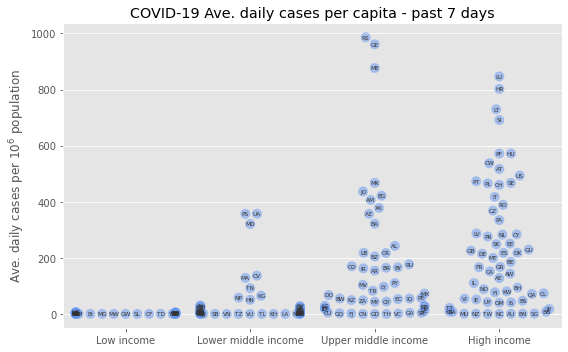

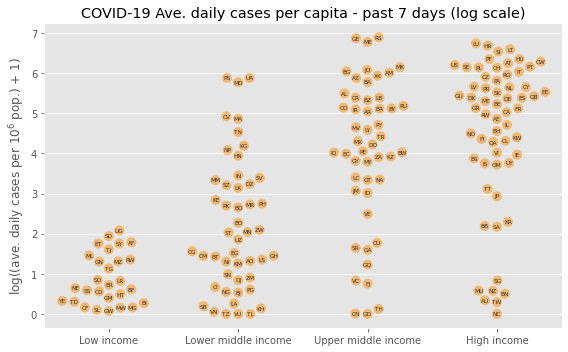

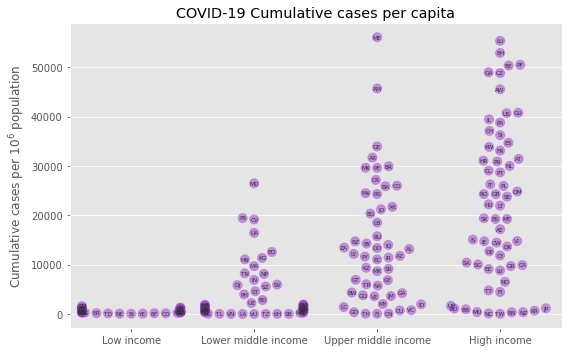

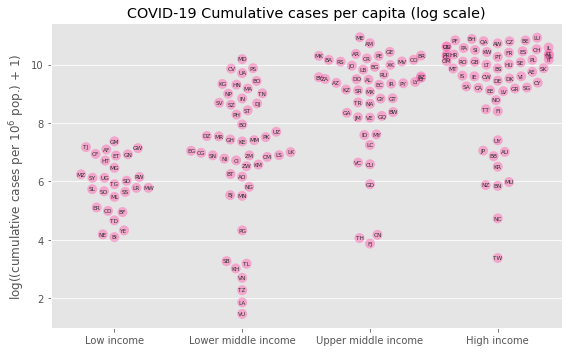

Deaths


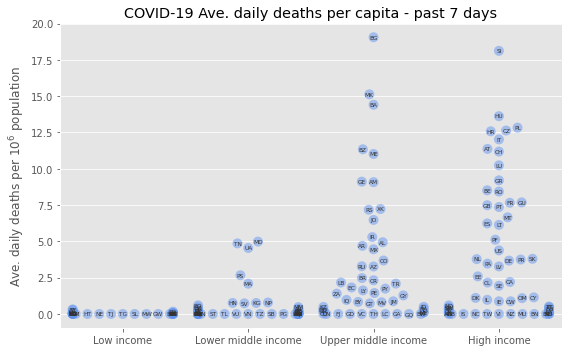

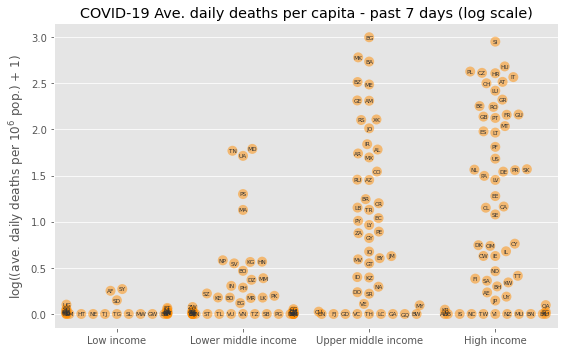

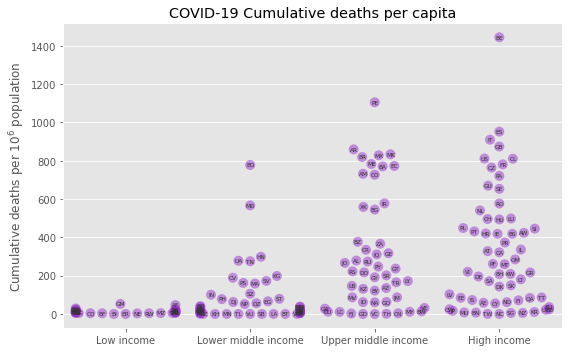

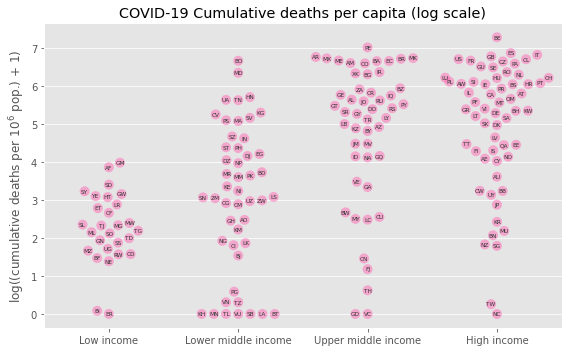

In [64]:
if True: # switch this output on/off

    # set-up
    PERIOD = 7 # days
    THRESH = 100_000 # people
    BAR_N = 40 # bars on chart
    keepers = get_larger_nations(population, THRESH)
    power, factor, pop_millions =  per_million_population(population)

    # for cases then deaths ...
    for mode, index in modes.items():
        print(mode)
    
        # world map ave. daily per capita for the past PERIOD days
        dataframe = adj_daily_data[index]
        rear_offsets = get_rear_offsets(dataframe, PERIOD)
        daily_ave = (get_recent_total(dataframe, rear_offsets, 
                                 PERIOD) / PERIOD)
        daily_ave_percapita = (daily_ave / pop_millions)[keepers]
        title = (f'COVID-19 Ave. daily {mode.lower()} per capita '
             f'- past {PERIOD} days')
        legend = (f'Ave. daily {mode.lower()} per '
                  f'$10^{power}$ population')
        map_world(daily_ave_percapita.copy(), title, legend)

        # swarm plot of daily average per capita
        title = (f'COVID-19 Ave. daily {mode.lower()} per capita '
             f'- past {PERIOD} days')
        ylabel = (f'Ave. daily {mode.lower()} per '
                 f'$10^{power}$ population')
        swarm(daily_ave_percapita.copy(), title, ylabel)
        
        # bar chart of the top recent performers
        top_tier = daily_ave.sort_values(ascending=True)[-BAR_N:]
        ps.plot_barh(
            series = np.round(top_tier.copy(), 1), 
            title=(f'COVID-19: Top {mode.lower()} - '
                  f'past {PERIOD} days'),
            xlabel=(f'Average daily {mode.lower()}'),
            tight=1.2,
            figsize=(8,8),
            lfooter=f'For nations with a population >= {THRESH:,}',
            savefig=f'{CHART_DIRECTORY}{I_PREFIX}Top-{mode.title()} (recent).png'
        ) 
        
        # bar chart of the top recent performers per capita
        top_tier = daily_ave_percapita.sort_values(ascending=True)[-BAR_N:]
        ps.plot_barh(
            series = np.round(top_tier.copy(), 1), 
            title=(f'COVID-19: Top {mode.lower()} per capita - '
                  f'past {PERIOD} days'),
            xlabel=(f'Average daily {mode.lower()} per '
                    f'$10^{power}$ population'),
            tight=1.2,
            figsize=(8,8),
            lfooter=f'For nations with a population >= {THRESH:,}',
            savefig=f'{CHART_DIRECTORY}{I_PREFIX}Top-{mode.title()} per capita (recent).png'
        )  

        # world map - average daily per capita past week - log scale
        log_daily_ave_percapita = np.log(daily_ave_percapita + 1) # manage outliers
        title = (f'COVID-19 Ave. daily {mode.lower()} per capita '
             f'- past {PERIOD} days (log scale)')
        legend = (f'log((average daily {mode.lower()} per '
              f'$10^{power}$-population) + 1)')
        map_world(log_daily_ave_percapita.copy(), title, legend)

        # swarm plot of daily average per capita - log scale
        title = (f'COVID-19 Ave. daily {mode.lower()} per capita '
             f'- past {PERIOD} days (log scale)')
        ylabel = (f'log((ave. daily {mode.lower()} per '
                 f'$10^{power}$ pop.) + 1)')
        swarm(log_daily_ave_percapita.copy(), title, ylabel, color='darkorange')        
        
        # world map - cumulative per capita
        cumulative = dataframe.sum()
        cumulative_percapita = (cumulative / pop_millions)[keepers]
        title = f'COVID-19 Cumulative {mode.lower()} per capita'
        legend = (f'Cumulative {mode.lower()} per '
                  f'$10^{power}$ population')
        map_world(cumulative_percapita.copy(), title, legend)

        # swarm plot of cumulative per capita
        title = f'COVID-19 Cumulative {mode.lower()} per capita'
        ylabel = (f'Cumulative {mode.lower()} per '
                  f'$10^{power}$ population')
        swarm(cumulative_percapita.copy(), title, ylabel, color='darkorchid')        

        # swarm plot of cumulative per capita - log scale
        log_cumulative_percapita = np.log(cumulative_percapita + 1)
        title = f'COVID-19 Cumulative {mode.lower()} per capita (log scale)'
        ylabel = (f'log((cumulative {mode.lower()} per '
                  f'$10^{power}$ pop.) + 1)')
        swarm(log_cumulative_percapita.copy(), title, ylabel, color='hotpink')        

        # bar chart of the top cumulative performers
        top_tier = series.sort_values(ascending=True)[-BAR_N:]
        ps.plot_barh(
            series = np.round(top_tier.copy(), 0).astype(int), 
            title=(f'COVID-19: Top cumulative {mode.lower()}'),
            xlabel=(f'Cumulative {mode.lower()}'),
            tight=1.2,
            figsize=(8,8),
            lfooter=f'For nations with a population >= {THRESH:,}',
            savefig=f'{CHART_DIRECTORY}{I_PREFIX}Top-{mode.title()} (cum).png'
        )

        # bar chart of the top cumulative performers per capita
        top_tier = series_percapita.sort_values(ascending=True)[-BAR_N:]
        ps.plot_barh(
            series = np.round(top_tier.copy(), 1), 
            title=(f'COVID-19: Top cumulative {mode.lower()} per capita'),
            xlabel=(f'Cumulative {mode.lower()} per '
                    f'$10^{power}$ population'),
            tight=1.2,
            figsize=(8,8),
            lfooter=f'For nations with a population >= {THRESH:,}',
            savefig=f'{CHART_DIRECTORY}{I_PREFIX}TOP-{mode.title()} per capita (cum).png'
        )

        # world map - cumulative - log scale
        log_series = np.log(series_percapita + 1)
        title = (f'COVID-19 Cumulative {mode.lower()} per capita '
                 f'(log scale)')
        legend = (f'log((cumulative {mode.lower()} per '
                  f'$10^{power}$ pop.) + 1)')
        map_world(log_series.copy(), title, legend)